# Statistical analysis comparing PEA software test set and flight data

Ref: https://chandramission.slack.com/archives/C01D83RUG0L/p1724092824832339


This provides information on the sampling and comparison of acquisition failure
statistics to flight data for two simulated datasets:

- ASVT: `PeaAcqModelCalDec2022Testing`
- SWATS: (s/w test set) https://chandramission.slack.com/archives/C01D83RUG0L/p1724092824832339

Sinces the SWATS data are undersampled in key regions, the acquisition failure 
comparison is done with the combination of ASVT and SWATS data. The SWATS data dominates
in most bins where there is substantial flight data.

## Summary

There is reasonable agreement between the simulated acquisition statistics and flight.
However, in some bins there is disagreement that is statistically significant. In most
cases of disagreement the simulated acquisition failure rate **exceeds** flight, meaning
that it is **conservative** to use the simulated data for acquisition probability
modeling.


In [1]:
import sys

sys.path.insert(0, "/Users/aldcroft/git/chandra_aca")

import functools

import matplotlib.pyplot as plt
import matplotlib.style
import numpy as np
from astropy.table import Table, vstack
from matplotlib import patches
from scipy.stats import binom

from utils_stats import (
    as_summary_table,
    flatten_pea_test_data,
    get_acq_stats_data,
    get_samples_successes,
    get_vals_and_bins,
    read_twiki_csv,
)

matplotlib.style.use("bmh")
%matplotlib inline

In [2]:
t_ccd_vals, t_ccd_bins = get_vals_and_bins([-13, -11, -9, -7, -5, -3])
mag_vals, mag_bins = get_vals_and_bins([8.25, 9, 9.5, 10, 10.5])
halfwidth_vals, halfwidth_bins = get_vals_and_bins([60, 80, 100, 120, 140, 160])

#
# Original sampling for ASVT data for reference
#
# t_ccd_vals, t_ccd_bins = get_vals_and_bins(
#     [-15, -13, -11, -9, -8, -7, -6, -5, -4, -3, -2, 0, 2]
# )
# mag_vals, mag_bins = get_vals_and_bins([8.0, 9.0, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75])

In [3]:
as_table = functools.partial(as_summary_table, t_ccd_vals=t_ccd_vals, mag_vals=mag_vals)

### Get flight data

In [4]:
flt_all = get_acq_stats_data()

### Get ASVT data from Dec 2022

In [5]:
topic = "PeaAcqModelCalDec2022Testing/"
name = "pea_analysis_2022_336_AcqProbModel_calibration_test_results.csv"
asvt8 = read_twiki_csv(topic + name)
asvt = flatten_pea_test_data(asvt8)
asvt = asvt["ccd_temp", "star_mag", "search_box_hw", "search_success"]
asvt.info

<Table length=22464>
     name       dtype 
-------------- -------
      ccd_temp   int64
      star_mag float64
 search_box_hw   int64
search_success   int64

### Get SWATS data from 2024_08_27

In [6]:
swats8 = Table.read(
    "../PEA_SW_TS_Acq_results_2024_08_27_w_more flight_like_maxmag.csv",
    format="ascii.csv",
)
swats = flatten_pea_test_data(swats8)
swats.rename_column("Mag_sim_info", "star_mag")
# Some bright stars around 1.0 mag
swats = swats[swats["star_mag"] > 4.0]
swats = swats["ccd_temp", "star_mag", "search_box_hw", "search_success"]
swats.info

<Table length=68997>
     name       dtype 
-------------- -------
      ccd_temp float64
      star_mag float64
 search_box_hw   int64
search_success   int64

In [7]:
def pformat_sampling(dat, add_mag=True):
    lines = []
    n_samp_all, _ = get_samples_successes(dat, mag_bins=mag_bins, t_ccd_bins=t_ccd_bins)
    for kk, halfw in enumerate((60, 80, 100, 120, 140, 160)):
        n_samp = n_samp_all[:, :, kk]
        lines.append(f"Halfwidth {halfw}:")
        lines.extend(as_table(n_samp, add_mag=add_mag).pformat_all())
        lines.append("")
    return lines

### Summary of sampling

This is the number of acquisition samples in each bin.

In [8]:
flt_lines = pformat_sampling(flt_all, add_mag=True)
asvt_lines = pformat_sampling(asvt, add_mag=False)
swats_lines = pformat_sampling(swats, add_mag=False)
_summary = Table(
    [flt_lines, asvt_lines, swats_lines], names=["Flight", "ASVT", "SWATS"]
)
_summary.pprint_all()

               Flight                                ASVT                               SWATS               
------------------------------------ ----------------------------------- -----------------------------------
                       Halfwidth 60:                       Halfwidth 60:                       Halfwidth 60:
mag  -13.0 -11.0 -9.0 -7.0 -5.0 -3.0  |  -13.0 -11.0 -9.0 -7.0 -5.0 -3.0  |  -13.0 -11.0 -9.0 -7.0 -5.0 -3.0
---- ----- ----- ---- ---- ---- ---- --- ----- ----- ---- ---- ---- ---- --- ----- ----- ---- ---- ---- ----
8.25     4     7   20   13    5    2   |    36    36   36   72   72   72   |     0     2    6   12    7   12
 9.0    18   129  375  286   62    2   |    36    36   36   72   72   72   |     3     1    5    8    6    8
 9.5   129   407  399  246  143   11   |    36    36   36   72   72   72   |     0     4   33  133   45  133
10.0   111   254  523  346  164    9   |    72    72   72  144  144  144   |    13    78  178  245  234  246
10.5    40   187  1

### Overview of coverage in CCD temperature and magnitude for SWATS data

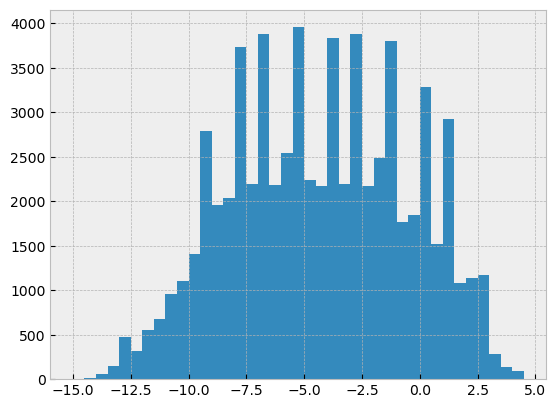

In [9]:
plt.hist(swats["ccd_temp"], bins=np.arange(-15, 5, 0.5));

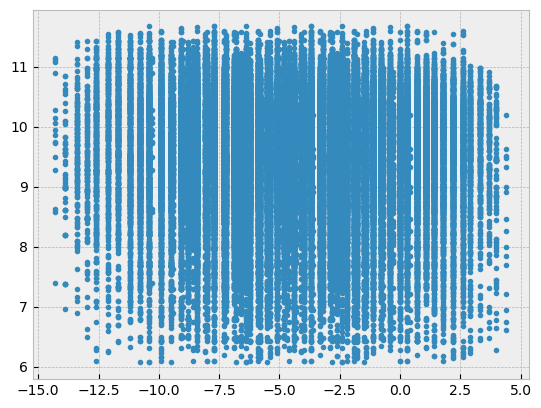

In [10]:
plt.plot(swats["ccd_temp"], swats["star_mag"], ".");

### Define simulated dataset as composite of ASVT and SWATS

In [11]:
sim_all = vstack([asvt, swats])

### Get the number of acquisition samples and successes in the defined bins

In [12]:
n_samp_sim_all, n_succ_sim_all = get_samples_successes(
    sim_all, mag_bins=mag_bins, t_ccd_bins=t_ccd_bins
)

In [13]:
n_samp_flt_all, n_succ_flt_all = get_samples_successes(
    flt_all, mag_bins=mag_bins, t_ccd_bins=t_ccd_bins
)

In [14]:
def calc_diff_pmf(p, pmf1, pmf2):
    dp = p[1] - p[0]  # assume uniform grid
    pmf1 = pmf1 / np.sum(pmf1)
    pmf2 = pmf2 / np.sum(pmf2)

    i0 = int(1 / dp)
    n_out = 2 * i0 + 1
    x = (np.arange(n_out) - i0) * dp
    out = np.zeros(n_out)
    p2 = p
    for i1, p1 in enumerate(p):
        d_pmf12 = pmf1[i1] * pmf2
        i_out = np.round((p1 - p2) / dp).astype(int) + i0
        out[i_out] += d_pmf12

    return x, np.cumsum(out)

In [15]:
def plot_diff_pmf(k1, n1, k2, n2, title="", l1="", l2="", axes=None):
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(12, 4))
    ax0 = axes[0]
    ax1 = axes[1]
    dp = 0.001
    p = np.arange(0.0 + dp / 2, 1.0, dp)
    pmf1 = binom.pmf(k1, n1, p)
    pmf2 = binom.pmf(k2, n2, p)
    dp, cdf = calc_diff_pmf(p, pmf1, pmf2)

    ax0.plot(p, pmf1, label=f"k={k1} n={n1} {l1}")
    ax0.plot(p, pmf2, label=f"k={k2} n={n2} {l2}")
    ax0.grid(True)
    if title:
        ax0.set_title(title)
    ax0.set_xlabel("p")
    ax0.legend(loc="best")

    ax1.plot(dp, cdf)
    ax1.grid(True)
    ax1.set_title("CDF of difference")
    i10, i90 = np.searchsorted(cdf, [0.1, 0.9])
    p10, p90 = dp[[i10, i90]]
    patch = patches.Rectangle((p10, 0.1), p90 - p10, 0.8, fc="r", alpha=0.2, ec="k")
    ax1.add_patch(patch)
    ax1.set_xlim(-0.5, 0.5)
    ax1.axvline(0, color="r", ls="--")


## Compute CDF of difference between flight and PEA test set data

In [16]:
def plot_acq_failure_prob_distributions(halfwidth=60):
    print(f"Acq Failure Probability Distributions (halfwidth={halfwidth})")

    kk = list(halfwidth_vals).index(halfwidth)
    n_samp_asvt = n_samp_sim_all[:, :, kk]
    n_succ_asvt = n_succ_sim_all[:, :, kk]
    n_samp_flt = n_samp_flt_all[:, :, kk]
    n_succ_flt = n_succ_flt_all[:, :, kk]
    n_fail_flt = n_samp_flt - n_succ_flt
    n_fail_asvt = n_samp_asvt - n_succ_asvt

    ni, nj = n_samp_flt.shape
    # dp10 = np.zeros(shape=(ni, nj))
    # dp90 = np.zeros(shape=(ni, nj))
    # dp = 0.01
    # p = np.arange(0.0 + dp / 2, 1.0, dp)

    n_plot = np.count_nonzero((n_samp_flt >= 30) & (n_samp_asvt >= 30))
    # Truncate up to the nearest multiple of 3.
    n_row = int(np.ceil(n_plot / 2))
    fig, axes = plt.subplots(n_row, 4, figsize=(12, 3 * n_row))

    i_plot = 0
    for ii in range(0, ni):
        for jj in range(nj):
            if n_samp_flt[ii, jj] < 30 or n_samp_asvt[ii, jj] < 30:
                continue

            k1 = n_fail_flt[ii, jj]
            n1 = n_samp_flt[ii, jj]
            k2 = n_fail_asvt[ii, jj]
            n2 = n_samp_asvt[ii, jj]

            title = f"mag={mag_vals[ii]} T_ccd={t_ccd_vals[jj]}"
            plot_diff_pmf(
                k1,
                n1,
                k2,
                n2,
                title,
                "Flight",
                "Sim",
                axes=axes.flat[i_plot : i_plot + 2],
            )
            i_plot += 2

    fig.tight_layout()


Acq Failure Probability Distributions (halfwidth=60)


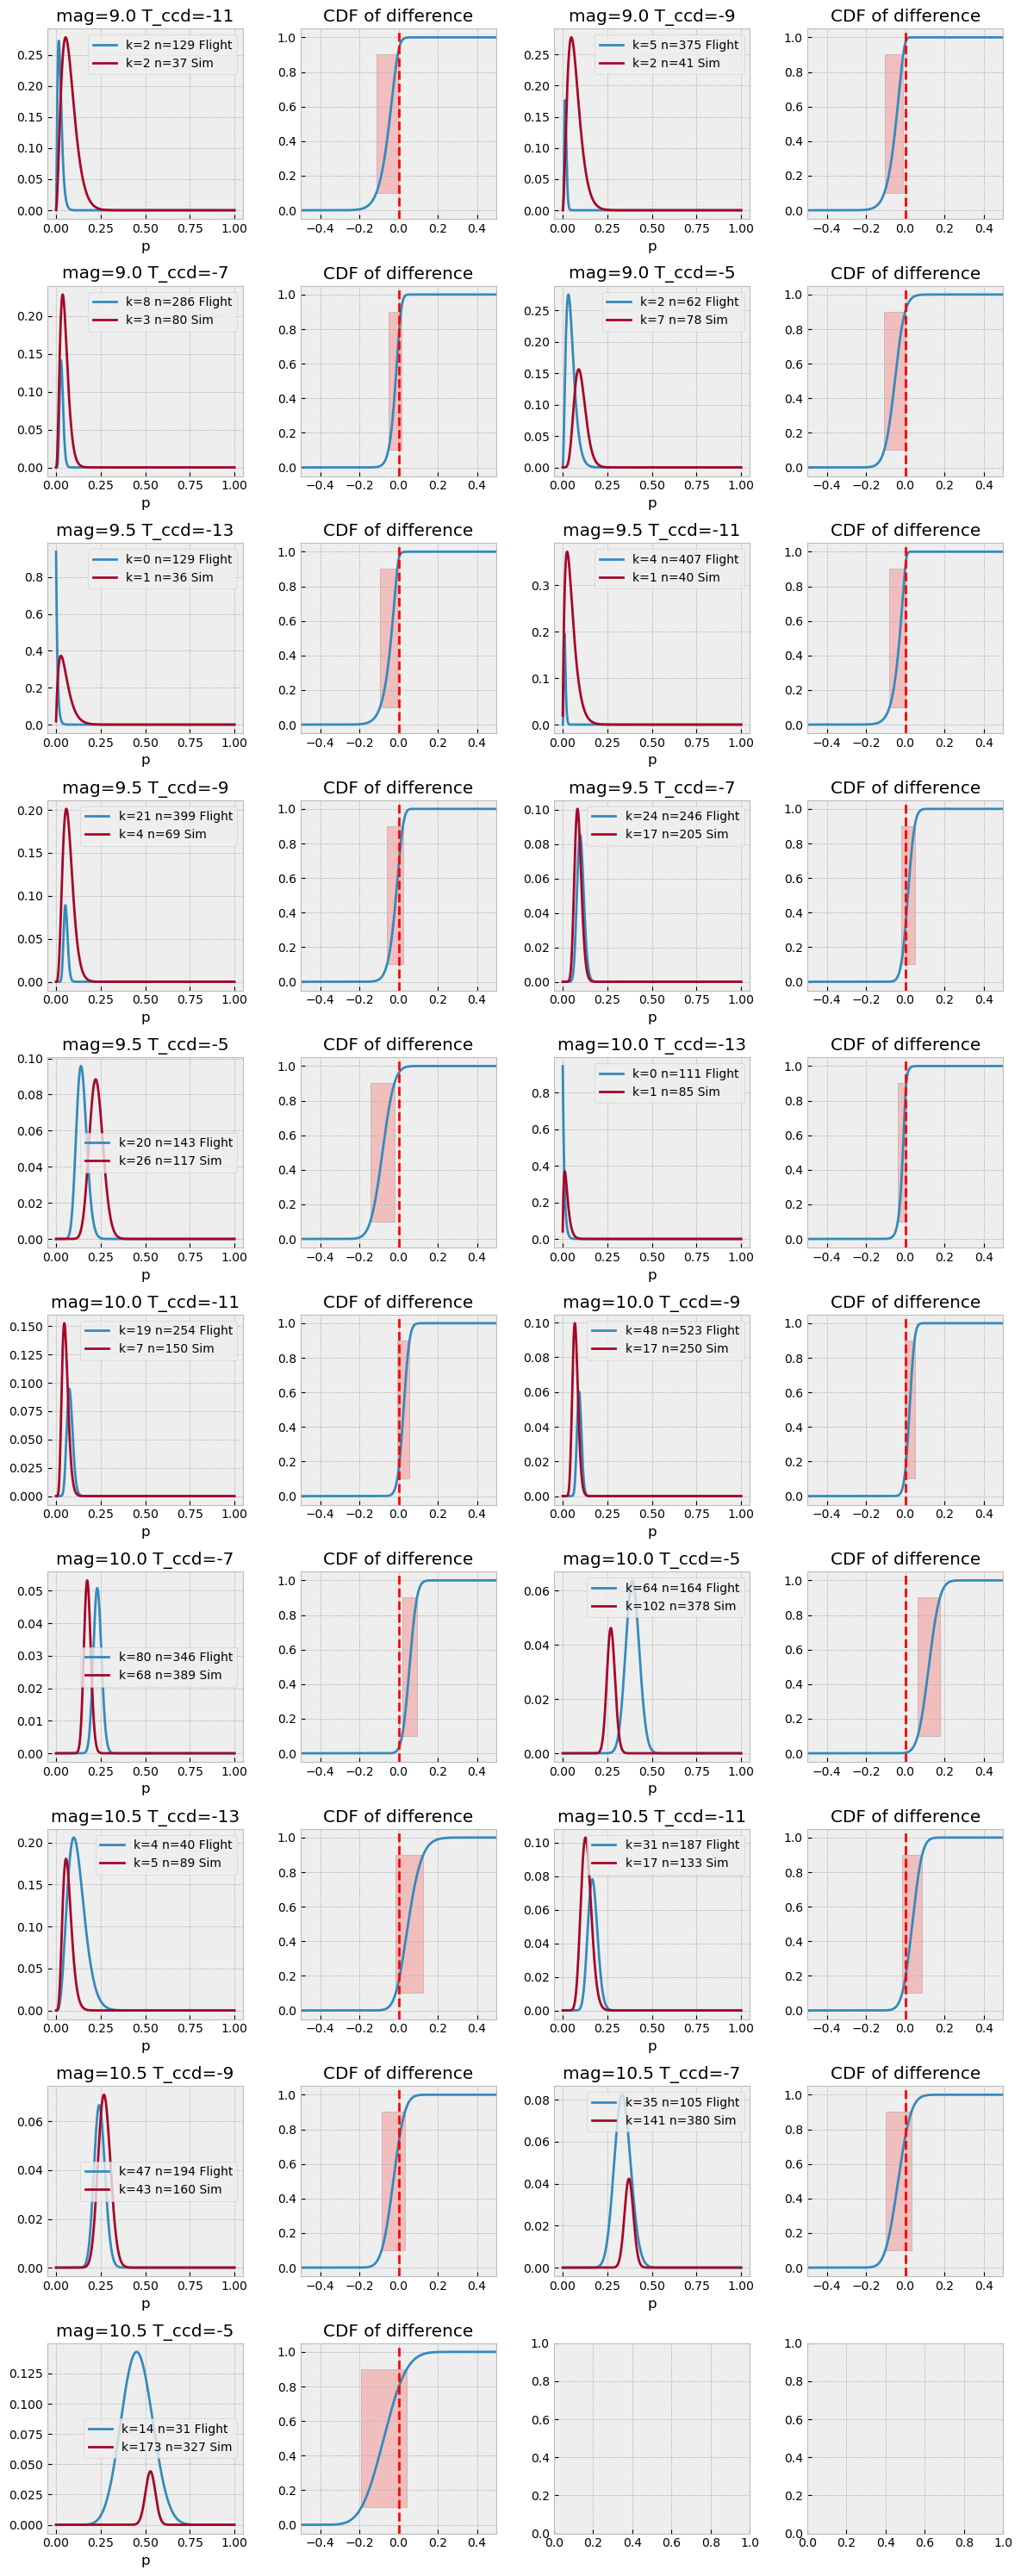

In [17]:
plot_acq_failure_prob_distributions(60)

Acq Failure Probability Distributions (halfwidth=160)


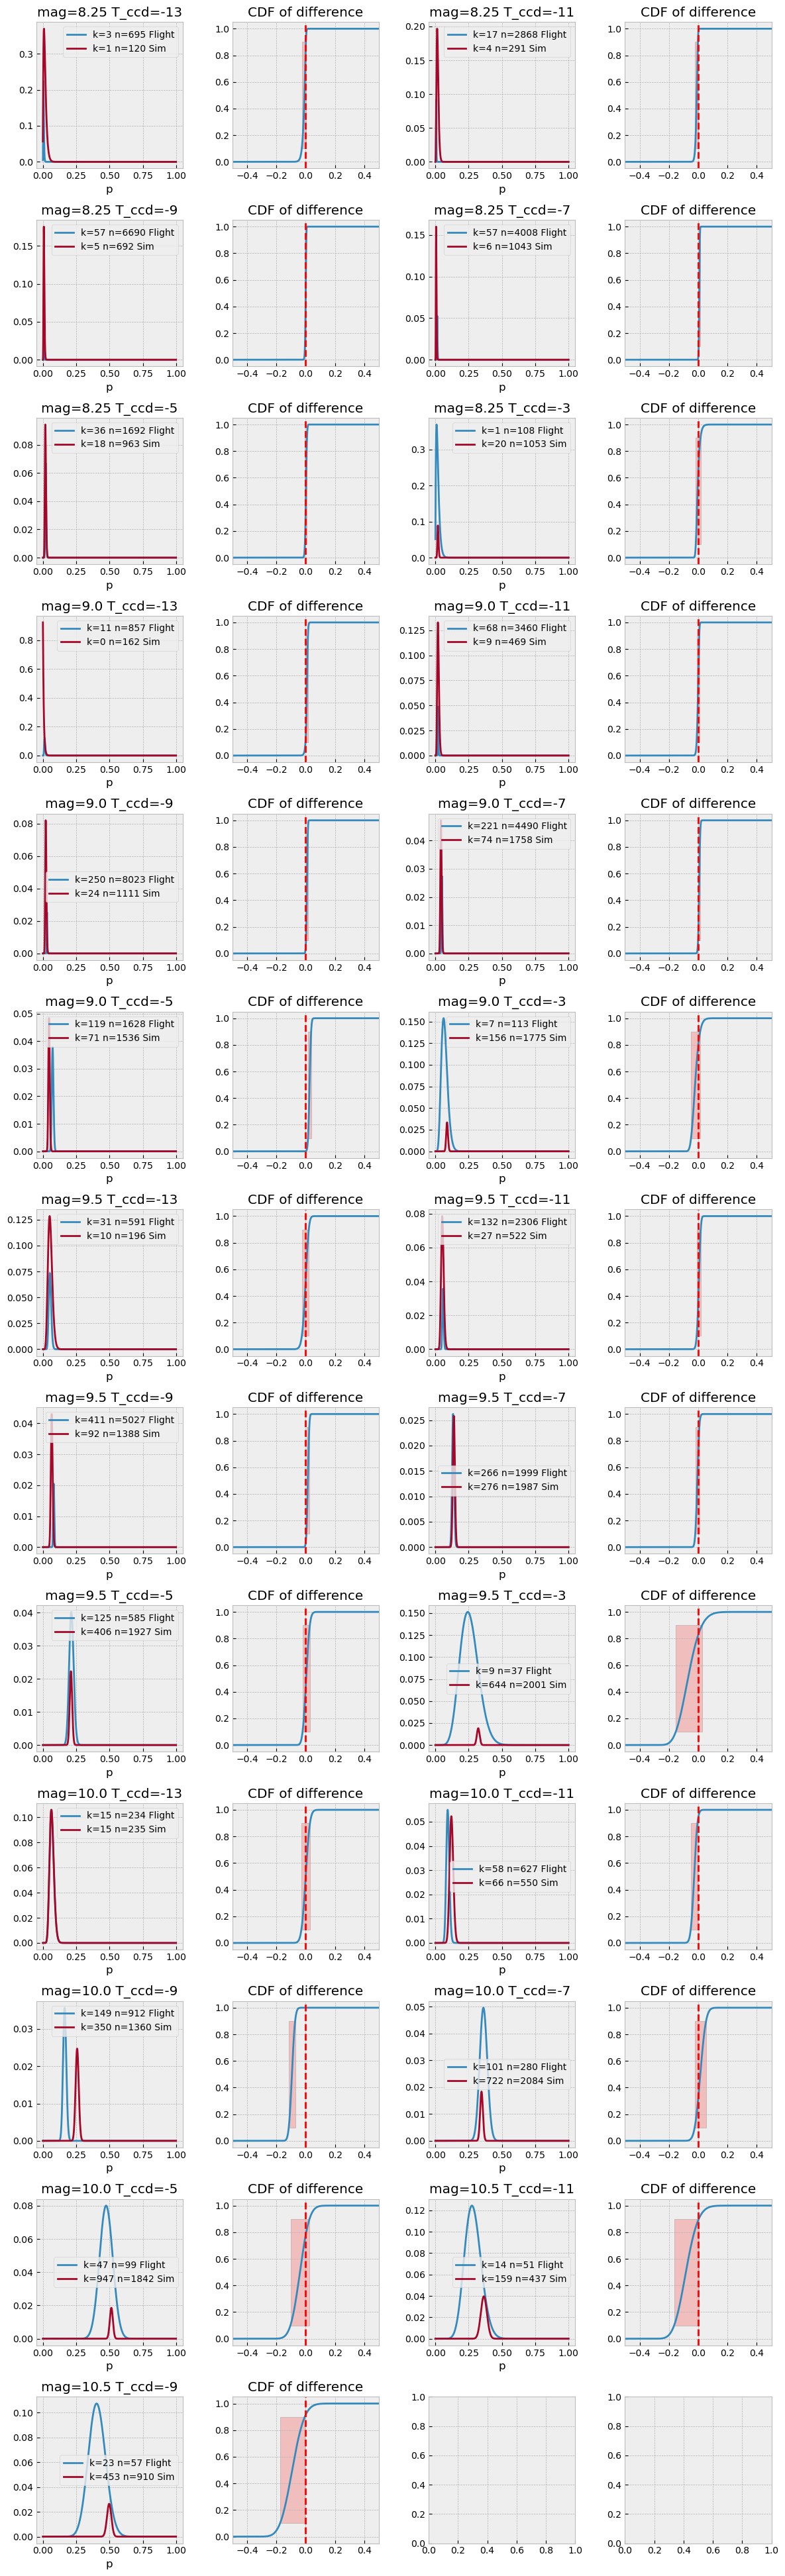

In [18]:
plot_acq_failure_prob_distributions(160)